In [1]:
# train
# train
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import models

from torchvision.models.inception import inception_v3
from dataloader import get_dataloader


In [2]:
from easydict import EasyDict
args = EasyDict({
    'model_name': 'wgan',
    'dataset_name': 'cifar10',
    'data_root': '../data/',
    'resolution': 32,
    'classes_to_include': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'batch_size': 128,
    'evaluation_size': 100,
    'device': 'cuda',
    'nz': 100,
    'ngf': 64,
    'ndf': 64,
    'nc': 3,
    'lr':0.0002,
    'total_iteration': 10000
})


In [3]:
# eval code here
@torch.no_grad()
def inception_score(generator, inception_model, args):
    generator.eval()
    
    upsample = nn.Upsample((399, 399), mode='bilinear')
    eval_sz = args.evaluation_size
    batch_sz = args.batch_size
    scores = []
    
    while eval_sz >=0: 
        bs = min(eval_sz, batch_sz)
        noise = torch.randn(bs, args.nz, 1, 1).to(device)
        imgs = generator(noise)
        imgs = upsample(imgs)
        x = inception_model(imgs)
        
        conditional_dist = F.softmax(x, dim=-1)
        marginal_dist = conditional_dist.mean(dim=0)

        for i in range(conditional_dist.size()[0]):
            score = F.kl_div(conditional_dist[i].log(), marginal_dist, reduction='sum')
            scores.append(score.item())
            
        eval_sz = eval_sz - batch_sz
    
    inception_score = torch.tensor(scores).mean(0).exp().item()
    generator.train()
    return inception_score
# inception_score(generator, inception_model, args)

# @torch.no_grad()
# def accuracy(generator, discriminator, test_loader, args):
#     generator.eval()
#     discriminator.eval()
#     correct, wrong = 0, 0
#     for batch in test_loader:
#         bs = batch.size(0)
#         noise = torch.randn(bs, args.nz, 1 ,1)
#         fake_imgs = generat
        
#     generator.train()
#     discriminator.train()
#     accuracy = correct / (correct + wrong)
#     return accuracy

In [4]:
device = args.device

model_classes = [m for m in dir(models) 
                   if m.lower() == args.model_name.lower()]
assert model_classes, f'Model name {args.model_name} does not exist'
components = getattr(models, model_classes[0]).components

generator = components['generator'](args).train().to(device)
discriminator = components['discriminator'](args).train().to(device)
criterion = components['criterion'](args)
optimizer_g = components['optimizer'](args, params=generator.parameters())
optimizer_d = components['optimizer'](args, params=discriminator.parameters())
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.to(args.device)
inception_model.eval()

losses_d, losses_g = [], []

train_loader = get_dataloader(args, train=True)
test_loader = get_dataloader(args, train=False)

train_iter = iter(train_loader)

for itr in range(args.total_iteration):
    try:
        imgs, _ = next(train_iter)
    except StopIteration:
        train_loader = get_dataloader(args, train=True)
        train_iter = iter(train_loader)
        imgs, _ = next(train_iter)
    imgs = imgs.to(device)

    # 1. Update Discriminator

    optimizer_d.zero_grad()
    real_pred = discriminator(imgs)

    noise = torch.randn(args.batch_size, args.nz, 1, 1).to(device)
    fake_imgs = generator(noise)
    fake_pred = discriminator(fake_imgs.detach())
    loss_d = criterion((fake_pred, real_pred), mode='discriminator_loss')
    losses_d.append(loss_d.item())

    loss_d.backward()
    optimizer_d.step()

    # 2. Update Generator
    optimizer_g.zero_grad()
    fake_pred = discriminator(fake_imgs)
    loss_g = criterion((fake_pred, real_pred), mode='generator_loss')
    losses_g.append(loss_g.item())

    loss_g.backward()
    optimizer_g.step()
    
    if (itr + 1) % int(args.total_iteration / 10) == 0:
        # evaluation
        generator_score = inception_score(generator, inception_model, args)
        
        print('-' * 20)
        print(f'Iteration: {itr + 1}')
        print(f'Discriminator Loss: {loss_d.item()}')
        print(f'Generator Loss: {loss_g.item()}')
        print(f'Inception Score: {generator_score}')


C:\Users\vulco\miniconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


--------------------
Iteration: 1000
Discriminator Loss: -4.19146728515625
Generator Loss: -52.674434661865234
Inception Score: 1.3319154977798462
--------------------
Iteration: 2000
Discriminator Loss: -43.76384735107422
Generator Loss: -282.7467041015625
Inception Score: 1.3699781894683838
--------------------
Iteration: 3000
Discriminator Loss: -103.20719909667969
Generator Loss: -449.74908447265625
Inception Score: 1.421242594718933
--------------------
Iteration: 4000
Discriminator Loss: -73.5394287109375
Generator Loss: -592.4150390625
Inception Score: 1.5124372243881226
--------------------
Iteration: 5000
Discriminator Loss: -210.903076171875
Generator Loss: -221.2845458984375
Inception Score: 1.5051510334014893
--------------------
Iteration: 6000
Discriminator Loss: -397.89990234375
Generator Loss: -1088.249267578125
Inception Score: 1.5125137567520142
--------------------
Iteration: 7000
Discriminator Loss: -317.384033203125
Generator Loss: -1384.6259765625
Inception Score:

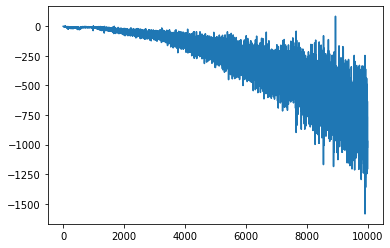

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses_d)
# plt.plot(losses_g)

In [6]:
def plot_images(imgs, ):
    import matplotlib.pyplot as plt
    import torchvision
    imgs = torchvision.utils.make_grid(imgs, normalize=True)
    plt.imshow(imgs.permute(1, 2, 0))

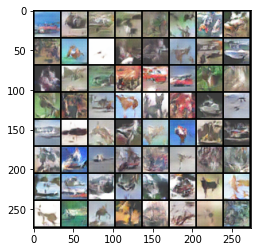

In [7]:
generator.eval().cpu()
with torch.no_grad():
    imgs = generator(torch.randn(64, args.nz, 1, 1))
plot_images(imgs)

In [ ]:
import time
import os
from datetime import datetime


discriminator.cpu()
generator.train()
ckpt = {
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict()
}
cur_time = datetime.now().strftime('%d%m%y.%H%M%S')
torch.save(ckpt, f'checkpoints/{args.model_name}.{args.dataset_name}.{args.total_iteration}.pt')
print(list(os.walk('checkpoints')))

In [7]:
import os
list(os.walk('checkpoints'))

[('checkpoints',
  [],
  ['dcgan.270621.131451.pt',
   'dcgan.270621.131500.pt',
   'dcgan.270621.131506.pt',
   'wgan.mnist.5000.pt'])]

In [81]:
# evaluation code here
import torch.nn.functional as F
from torchvision.models.inception import inception_v3
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.to(args.device)
inception_model.eval()
generator.to(args.device)
generator.eval()

@torch.no_grad()
def inception_score(generator, inception_model, args):
    generator.eval()
    
    upsample = nn.Upsample((399, 399), mode='bilinear')
    eval_sz = args.evaluation_size
    batch_sz = args.batch_size
    scores = []
    
    while eval_sz >=0: 
        bs = min(eval_sz, batch_sz)
        
        noise = torch.randn(args.batch_size, args.nz, 1, 1).to(device)
        imgs = generator(noise)
        imgs = upsample(imgs)
        x = inception_model(imgs)
        
        conditional_dist = F.softmax(x, dim=1)
        marginal_dist = conditional_dist.mean(dim=0)

        
        for i in range(conditional_dist.size()[0]):
            score = F.kl_div(conditional_dist[i].log(), marginal_dist)
            scores.append(score.item())
            
        eval_sz = eval_sz - batch_sz
    
    generator.train()
    inception_score = torch.tensor(scores).mean(0).exp().item()
    return inception_score
        
    # generate images
    # upsample to match 299 x 299
    # feed through network
    
    # softmax the outcome
    # kl-div on conditional and marginal distribution
inception_score(generator, inception_model, args)

C:\Users\vulco\miniconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 1.19 GiB (GPU 0; 11.00 GiB total capacity; 7.49 GiB already allocated; 503.75 MiB free; 8.91 GiB reserved in total by PyTorch)

torch.Size([10, 3, 399, 399])
torch.Size([10, 1000])


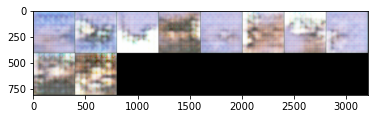

In [79]:
upsample = nn.Upsample((399, 399), mode='bilinear')

noise = torch.randn(10, 100, 1, 1).to(args.device)
imgs = generator(noise)
imgs = upsample(imgs)

plot_images(imgs.cpu())
print(imgs.size())
x = inception_model(imgs)
print(x.size())




In [74]:
import torch.nn.functional as F

conditional_dist = F.softmax(x, dim=1)
marginal_dist = conditional_dist.mean(dim=0)
print(marginal_dist.size())
scores = []
for i in range(conditional_dist.size()[0]):
    score = F.kl_div(conditional_dist[i].log(), marginal_dist)
    print(score)
    scores.append(score)
print(scores)
score = torch.stack(scores, dim=0).mean(0)
print(score.exp())
# print(conditional_distribution[0].sum())
# F.kl_div()

torch.Size([1000])
tensor(0.0001, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0009, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0010, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<KlDivBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<KlDivBackward>)
[tensor(0.0001, device='cuda:0', grad_fn=<KlDivBackward>), tensor(0.0006, device='cuda:0', grad_fn=<KlDivBackward>), tensor(0.0009, device='cuda:0', grad_fn=<KlDivBackward>), tensor(0.0004, device='cuda:0', grad_fn=<KlDivBackward>), tensor(0.0010, device='cuda:0', grad_fn=<KlDivBackward>), tensor(0.0002, device='cuda:0', grad_fn=<KlDivBackward>), tensor(0.0005, device='cuda:0', grad_fn=<KlDivBackward>), tens

In [62]:
print(conditional_dist[0].sum())
print(marginal_dist.sum())

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


In [71]:

F.kl_div(torch.tensor([0.3, 0.7]), torch.tensor([0.5, 0.5]), log_target=True)

tensor(-0.5966)